# Second assignment: Analyse your "realistic" graph

In [1]:
import networkx as nx
from networkx.algorithms import community
import numpy as np
import matplotlib.pyplot as plt

In [40]:
G = nx.Graph()
edges = nx.read_edgelist('aa - Copia1.txt')
G.add_edges_from(edges.edges())


EdgeView([('0', '1'), ('0', '2'), ('0', '3'), ('0', '4'), ('0', '5'), ('1', '2'), ('1', '4'), ('1', '5'), ('1', '15'), ('2', '11'), ('2', '12'), ('2', '13'), ('2', '14'), ('3', '63'), ('3', '64'), ('3', '65'), ('3', '66'), ('3', '67'), ('4', '7'), ('4', '16'), ('4', '17'), ('4', '18'), ('4', '19'), ('4', '73'), ('4', '74'), ('4', '75'), ('4', '109'), ('4', '110'), ('4', '180'), ('4', '282'), ('4', '431'), ('4', '629'), ('4', '630'), ('5', '6'), ('5', '7'), ('5', '8'), ('5', '9'), ('5', '10'), ('5', '139'), ('5', '154'), ('5', '608'), ('5', '612'), ('15', '68'), ('15', '69'), ('15', '70'), ('15', '71'), ('15', '72'), ('15', '105'), ('15', '107'), ('15', '178'), ('15', '299'), ('15', '301'), ('15', '508'), ('15', '509'), ('11', '6'), ('11', '9'), ('11', '20'), ('11', '25'), ('11', '26'), ('11', '45'), ('11', '46'), ('11', '47'), ('11', '57'), ('11', '58'), ('11', '59'), ('11', '88'), ('11', '265'), ('11', '266'), ('11', '267'), ('11', '402'), ('11', '500'), ('11', '501'), ('11', '545'), 

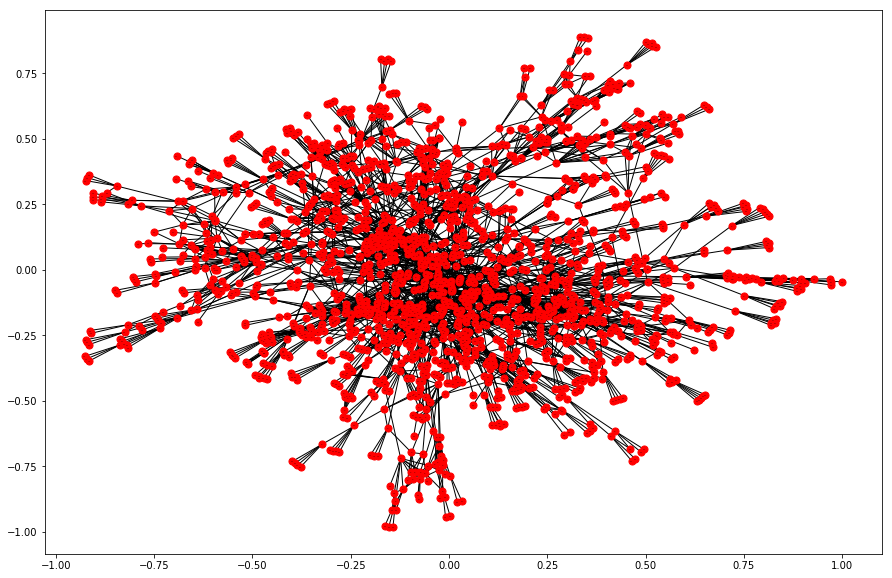

In [75]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G,font_size=0,node_size=50)

In [78]:
# identify largest connected component
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
G0 = Gcc[0]

if(len(G)==len(G0)):
    print("Largest connected component is the whole graph")


Largest connected component is the whole graph


In [14]:
degrees = [val for (node, val) in G0.degree]
avg_degree = sum(degrees)/len(degrees)
density = nx.density(G0)
diameter = nx.diameter(G0)
avg_path_lenght = nx.average_shortest_path_length(G0)
avg_clust = nx.average_clustering(G)
print("avg degree: ",avg_degree)
print("density: ",density)
print("diameter: ",diameter)
print("avg_path_lenght: ",avg_path_lenght)
print("avg_clustering coeff: ",avg_clust)


avg degree:  4.410974244120941
density:  0.0024711340303198545
diameter:  16
avg_path_lenght:  6.983947980087891


In [15]:
from networkx.algorithms import community

communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))

[['0',
  '1',
  '10',
  '100',
  '1000',
  '1001',
  '1002',
  '1003',
  '1004',
  '1005',
  '1006',
  '1007',
  '101',
  '1019',
  '102',
  '1020',
  '1021',
  '1022',
  '1023',
  '1024',
  '1025',
  '1026',
  '1027',
  '1028',
  '1029',
  '103',
  '1030',
  '1031',
  '1032',
  '1033',
  '1034',
  '1035',
  '1036',
  '1037',
  '1038',
  '1039',
  '104',
  '1040',
  '1041',
  '1042',
  '1043',
  '1044',
  '1045',
  '1046',
  '1047',
  '1048',
  '1049',
  '105',
  '1050',
  '1051',
  '1052',
  '1053',
  '106',
  '1061',
  '1062',
  '1063',
  '1064',
  '1065',
  '1066',
  '1067',
  '1068',
  '1069',
  '107',
  '1070',
  '1071',
  '1076',
  '1077',
  '1078',
  '1079',
  '108',
  '1083',
  '1089',
  '109',
  '1090',
  '1093',
  '1097',
  '11',
  '110',
  '111',
  '112',
  '1120',
  '1121',
  '1122',
  '1123',
  '1124',
  '1125',
  '1126',
  '1127',
  '1128',
  '1129',
  '113',
  '1130',
  '1131',
  '1132',
  '1136',
  '1137',
  '1138',
  '1139',
  '114',
  '1140',
  '1141',
  '1142',
  '11

In [83]:
from networkx.algorithms.community import greedy_modularity_communities

c = list(greedy_modularity_communities(G))
print("Number of communities:",len(c)) # num of communities
# each element of c contains the list of nodes belongs to each communities
for i in range(len(c)):
    print("community",i,"contains",len(c[i]),"nodes")

Number of communities: 49
community 0 contains 270 nodes
community 1 contains 180 nodes
community 2 contains 178 nodes
community 3 contains 177 nodes
community 4 contains 85 nodes
community 5 contains 78 nodes
community 6 contains 64 nodes
community 7 contains 52 nodes
community 8 contains 50 nodes
community 9 contains 45 nodes
community 10 contains 43 nodes
community 11 contains 33 nodes
community 12 contains 33 nodes
community 13 contains 33 nodes
community 14 contains 28 nodes
community 15 contains 28 nodes
community 16 contains 26 nodes
community 17 contains 25 nodes
community 18 contains 24 nodes
community 19 contains 22 nodes
community 20 contains 22 nodes
community 21 contains 22 nodes
community 22 contains 21 nodes
community 23 contains 19 nodes
community 24 contains 17 nodes
community 25 contains 16 nodes
community 26 contains 16 nodes
community 27 contains 16 nodes
community 28 contains 16 nodes
community 29 contains 15 nodes
community 30 contains 15 nodes
community 31 contai

In [84]:
llist = [] # build a list of color for each community
for node in G:
    for i,comm in enumerate(c):
        if node in comm:
            llist.append(i)
            break    
#print(llist)

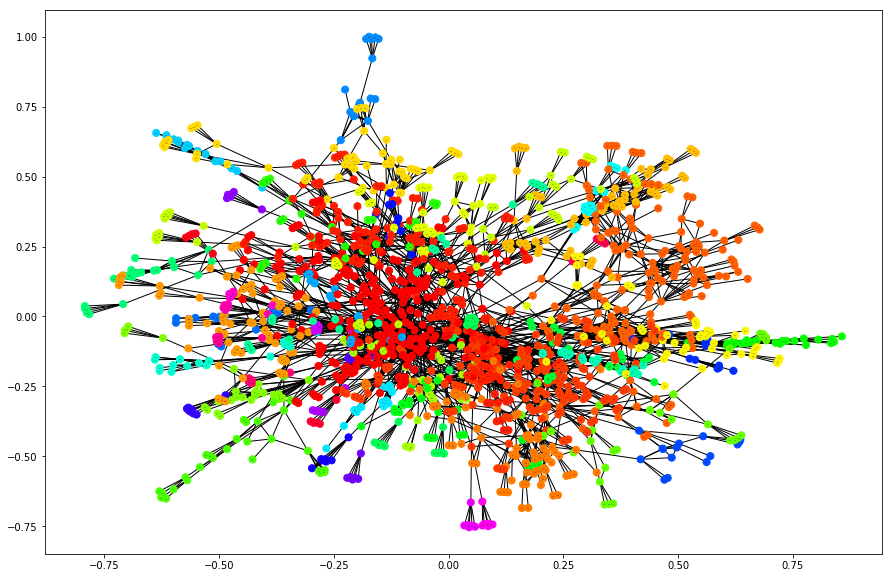

In [72]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G,node_color=llist,cmap = 'hsv',vmin = 0,vmax=48,font_size=0,node_size=50)

**Does the graph have the same characteristics of a random or a power-law network?**<br>


'2.2'

**Which are the most important nodes, with respect to a given centrality measure?**<br>


In [100]:
aux = nx.degree_centrality(G)
a = [key for (key, value) in sorted(aux.items(),reverse=True)]
print(a)

['999', '998', '997', '996', '995', '994', '993', '992', '991', '990', '99', '989', '988', '987', '986', '985', '984', '983', '982', '981', '980', '98', '979', '978', '977', '976', '975', '974', '973', '972', '971', '970', '97', '969', '968', '967', '966', '965', '964', '963', '962', '961', '960', '96', '959', '958', '957', '956', '955', '954', '953', '952', '951', '950', '95', '949', '948', '947', '946', '945', '944', '943', '942', '941', '940', '94', '939', '938', '937', '936', '935', '934', '933', '932', '931', '930', '93', '929', '928', '927', '926', '925', '924', '923', '922', '921', '920', '92', '919', '918', '917', '916', '915', '914', '913', '912', '911', '910', '91', '909', '908', '907', '906', '905', '904', '903', '902', '901', '900', '90', '9', '899', '898', '897', '896', '895', '894', '893', '892', '891', '890', '89', '889', '888', '887', '886', '885', '884', '883', '882', '881', '880', '88', '879', '878', '877', '876', '875', '874', '873', '872', '871', '870', '87', '869',

**Are the paths short with respect to the size of the network?**<br>

**Is the network dense?**<br>
